# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss_values = []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        return 1.0 / (1 + np.exp(-np.dot(X,weights)))
                      
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        return np.mean(np.log(1 + np.exp(-(np.dot(weights,x.transpose()))*y))) + (1 / (2*self.C)) * np.linalg.norm(weights)
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        for i in range(self.max_iter):
            delta = np.dot(X_ext.transpose(), (y * (1 - 1 / (1 + np.exp(-np.dot(self.weights_,X_ext.transpose())*y)))))
            delta = -delta / len(y) + self.weights_ / self.C
            self.weights_ -= self.eta * delta
            self.loss_values.append(self.get_loss(X_ext, self.weights_, y))
            if np.linalg.norm(delta) < self.tol:
                break
    
    
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return np.where(self.predict_proba(X) >= 0.5, 1, -1)

In [5]:
from sklearn import datasets
from sklearn import metrics

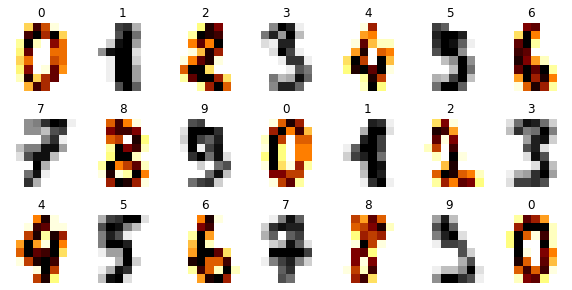

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [11]:
lr_clf.fit(X_train, y_train)

In [12]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [13]:
model = CustomLogisticRegression()

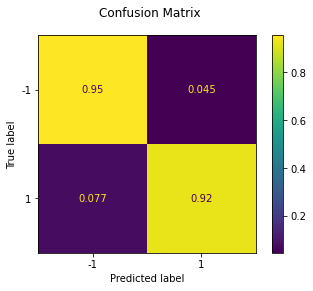

In [14]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [15]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [16]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

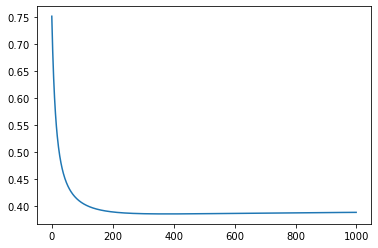

In [17]:
plt.plot(model.loss_values)

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

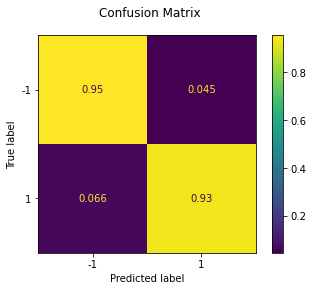

0.9157967988865693 0.9444444444444444


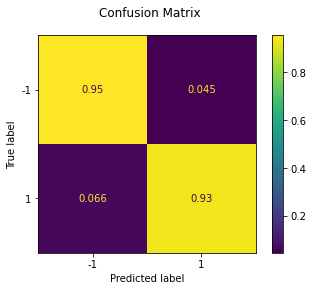

0.9157967988865693 0.9444444444444444


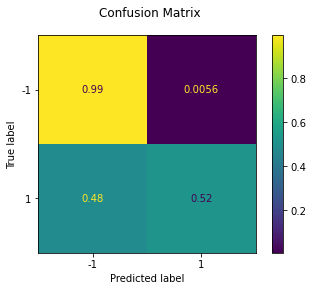

0.7731384829505915 0.7527777777777778


In [18]:
learning_rates = [0.003, 0.005, 0.01]
for i in learning_rates:
    model = CustomLogisticRegression(eta=i)
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
    print(train_acc, test_acc)

With eta too big, we can overlook optimal minimum. With smaller values of eta we less likely to miss minimum but then we need more time to converge.
Basically, here with bigger eta, our accuracy is decreasing for the odd number, but not for the even.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

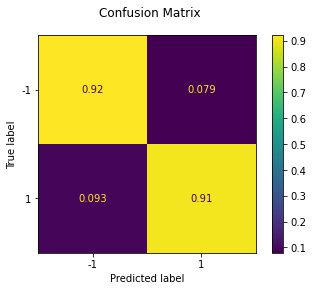

0.8879610299234516 0.9138888888888889


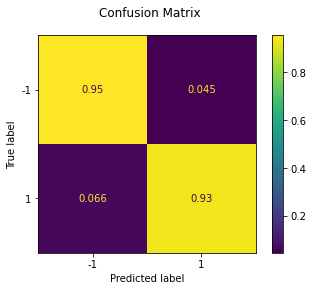

0.9151009046624913 0.9444444444444444


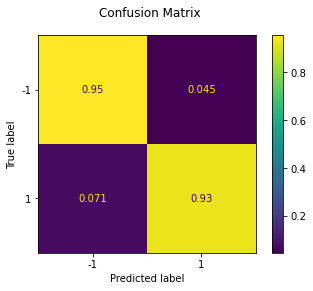

0.9151009046624913 0.9416666666666667


In [19]:
reg_params = [0.1, 5, 10]
for i in reg_params:
    model = CustomLogisticRegression(C=i)
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
    print(train_acc, test_acc)

With higher C (weakeining regularization parameter, since C is inverse of it), we achieve slightly higher accuracy but this way we may not differentiate output parameters.
With smaller C values (higher regularization itself), the accuracy is a bit lower, but this wey we can prevent overfitting.

**(0.5 points)** Compare zero initialization and random initialization. 

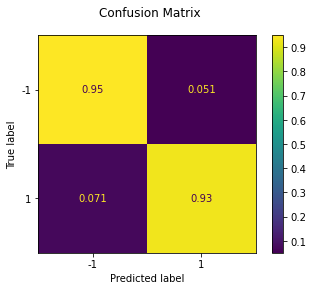

(0.9116214335421016, 0.9388888888888889)

In [20]:
model = CustomLogisticRegression(zero_init=True)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
train_acc, test_acc

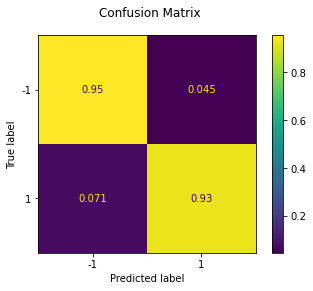

(0.9123173277661796, 0.9416666666666667)

In [21]:
model = CustomLogisticRegression(zero_init=False, random_state=5)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
train_acc, test_acc

With random state on, we achieve higher accuracy on a test set.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [22]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        return sklearn.metrics.pairwise.euclidean_distances(X,Y)
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        sum_of_weights = []
        for i in self.classes_:
            weights_of_class = 0
            for j in range(len(y)):
                if y[j] == i:
                    weights_of_class += weights[j]
            sum_of_weights.append(weights_of_class)
        return sum_of_weights
            
    
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            close_ind = P.argsort(axis=1)[:,:self.n_neighbors]
            least_distances = P[np.arange(len(P))[:,None], close_ind]
            closest_class = self.y[close_ind]
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1 / np.maximum(least_distances, self.eps)
            count_class = []
            for i in range(len(P)):
                count_class.append(self.get_class_weights(closest_class[i], weights_of_points[i]))
            return np.array(np.array(count_class) / np.expand_dims(np.array(count_class).sum(axis=1), 1))                                                         
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
    
    
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return self.predict_proba(X).argmax(axis=1)

In [23]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [24]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [25]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

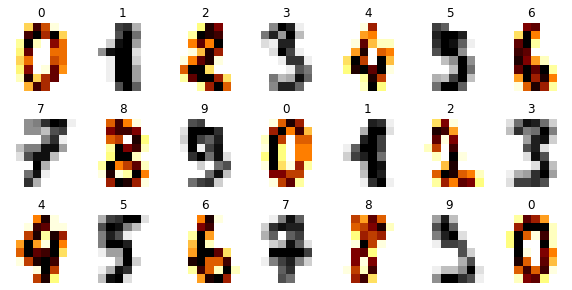

In [26]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [27]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [28]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

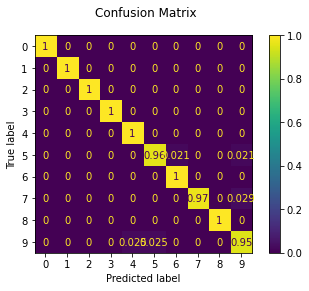

In [29]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [30]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

4/9, 5/6, 5/9, 7/9 are confused.
Perhaps 5 and 6 could look similar, 4 and 9 same.
The others could be, but not so obvious.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

0.5007317088840914 1.0


<AxesSubplot:ylabel='Count'>

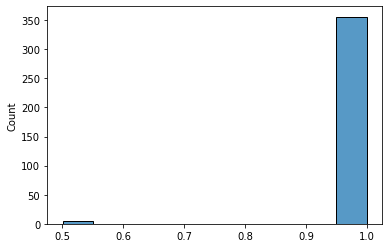

In [31]:
model = CustomKNeighborsClassifier(n_neighbors=2, weights='distance')
model.fit(X_train, y_train)
prob = model.predict_proba(X_test)
print(prob.max(axis=1).min(), prob.max(axis=1).max())
sns.histplot(prob.max(axis=1))

0.4481987383724928 1.0


<AxesSubplot:ylabel='Count'>

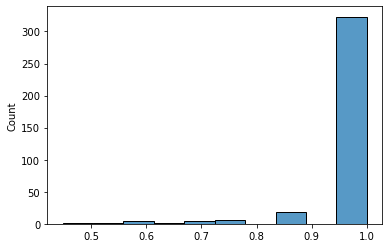

In [32]:
model = CustomKNeighborsClassifier(n_neighbors=7, weights='distance')
model.fit(X_train, y_train)
prob = model.predict_proba(X_test)
print(prob.max(axis=1).min(), prob.max(axis=1).max())
sns.histplot(prob.max(axis=1))

0.2972415499264734 1.0


<AxesSubplot:ylabel='Count'>

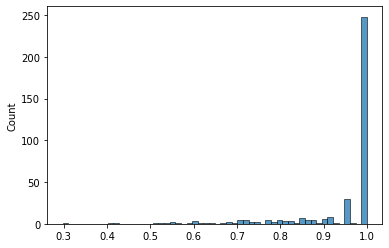

In [33]:
model = CustomKNeighborsClassifier(n_neighbors=20, weights='distance')
model.fit(X_train, y_train)
prob = model.predict_proba(X_test)
print(prob.max(axis=1).min(), prob.max(axis=1).max())
sns.histplot(prob.max(axis=1))

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

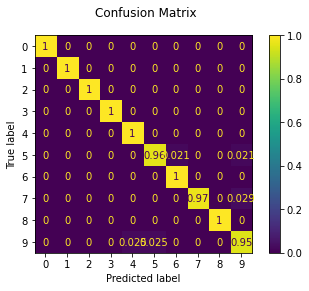

(0.9895615866388309, 0.9861111111111112)

In [34]:
model = KNeighborsClassifier(n_neighbors=5, weights='uniform')
fit_evaluate(model, X_train, y_train, X_test, y_test)

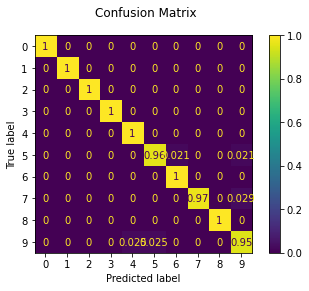

(1.0, 0.9861111111111112)

In [35]:
model = KNeighborsClassifier(n_neighbors=5, weights='distance')
fit_evaluate(model, X_train, y_train, X_test, y_test)

Uniform provides a way to ensure that all the nearest neighbours contribute to the prediction.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

Taxicab geometry (Minkowski)

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

Recommendation system: cosine distance.

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [36]:
PATH = "./data/"

In [37]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [38]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [39]:
surv_numb = data.groupby('Survived')['Survived'].count()
surv_numb

Survived
0    57226
1    42774
Name: Survived, dtype: int64

In [40]:
sex_numb = data.groupby('Sex')['Sex'].count()
sex_numb

Sex
female    43886
male      56114
Name: Sex, dtype: int64

<AxesSubplot:xlabel='Sex', ylabel='count'>

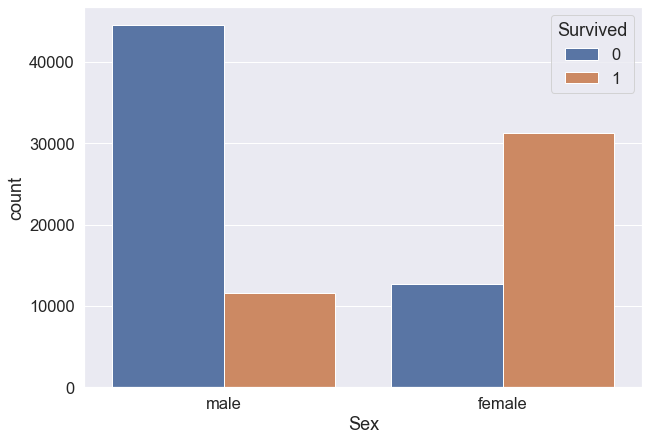

In [41]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.5)
sns.countplot(x=data["Sex"],hue = data["Survived"],data = data)

<AxesSubplot:xlabel='Survived', ylabel='Sex'>

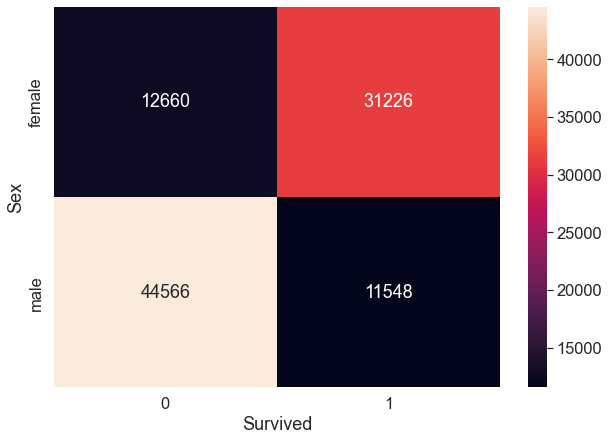

In [42]:
tit_data_by_sex_surv = data.groupby(['Sex', 'Survived'])
sex_survived = tit_data_by_sex_surv.size().unstack()
plt.figure(figsize=(10,7))
sns.set(font_scale=1.5)
sns.heatmap(sex_survived, annot = True, fmt ="d")

There were more males than females on board; more than a half of passengers died.
From above we can see that the number of women survived is higher than not survived, with men it's vice versa
It's clear that percentage of survived women are far bigger than men. 
This is due to the fact that women are always being first for the rescue.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

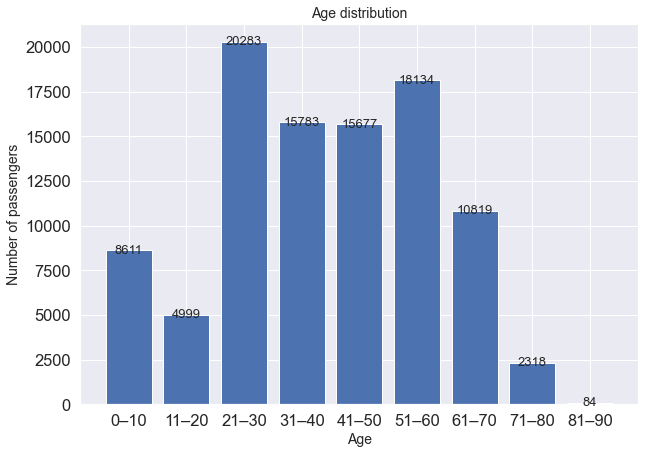

In [43]:
plt.figure(figsize=(10,7))
ages = data[data['Age'].notnull()]['Age'].values
ages_hist = np.histogram(ages, bins=[0,10,20,30,40,50,60,70,80,90])
ages_hist_labels = ['0–10', '11–20', '21–30', '31–40', '41–50', '51–60', '61–70', '71–80', '81–90']
plt.title('Age distribution', fontsize=14)
plt.bar(ages_hist_labels, ages_hist[0])
plt.xlabel('Age', fontsize=14)
plt.ylabel('Number of passengers', fontsize=14)
for i, bar in zip(ages_hist[0], range(9)):
    plt.text(bar, i+3, str(int(i)), fontsize=13,
             horizontalalignment='center', verticalalignment='center')

In [44]:
data["Age"].describe()

count    96708.000000
mean        38.355472
std         18.313556
min          0.080000
25%         25.000000
50%         39.000000
75%         53.000000
max         87.000000
Name: Age, dtype: float64

Average age of survived passengers is 40.55379931430776
Median age of survived passengers is 43.0


<Figure size 1440x720 with 0 Axes>

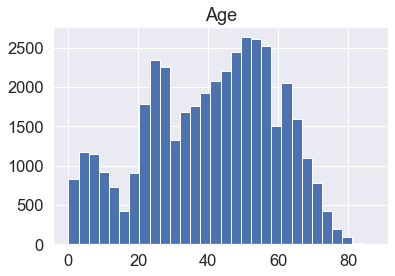

In [45]:
plt.figure(figsize=(20,10))
data[data['Survived'] == 1].hist(column='Age', bins=30)
average_age_surv = data[data['Survived'] == 1]['Age'].mean()
median_age_surv = data[data['Survived'] == 1]['Age'].median()
print('Average age of survived passengers is ' + str(average_age_surv))
print('Median age of survived passengers is ' + str( median_age_surv))

Average age of drowned passengers is 36.708694881533724
Median age of drowned passengers is 36.0


<Figure size 1440x720 with 0 Axes>

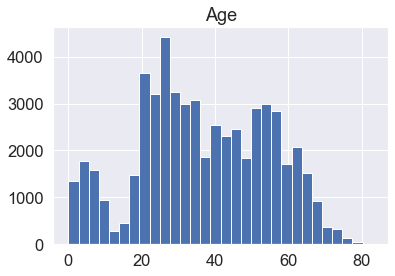

In [46]:
plt.figure(figsize=(20,10))
data[data['Survived'] == 0].hist(column='Age', bins=30)
average_age_surv = data[data['Survived'] == 0]['Age'].mean()
median_age_surv = data[data['Survived'] == 0]['Age'].median()
print('Average age of drowned passengers is ' + str(average_age_surv))
print('Median age of drowned passengers is ' + str( median_age_surv))

Most of people were between 21-30 years old, least - of 81-90 (distribution is not really normal, but close to it).
Average and median ages of survived passengers are higher, perhaps due to the fact that older people as women are usually first for resque procedures.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [47]:
pcl_numb = data.groupby('Pclass')['Pclass'].count()
pcl_numb

Pclass
1    30315
2    28679
3    41006
Name: Pclass, dtype: int64

([<matplotlib.patches.Wedge at 0x121671880>,
 [Text(0.6377256168583579, 0.8962734167666846, 'first'),
  Text(-1.03853717094496, 0.3625472997632711, 'second'),
  Text(0.3066911371571331, -1.0563808718399177, 'third')],
 [Text(0.34785033646819524, 0.48887640914546426, '30%'),
  Text(-0.5664748205154326, 0.19775307259814784, '29%'),
  Text(0.16728607481298166, -0.5762077482763187, '41%')])

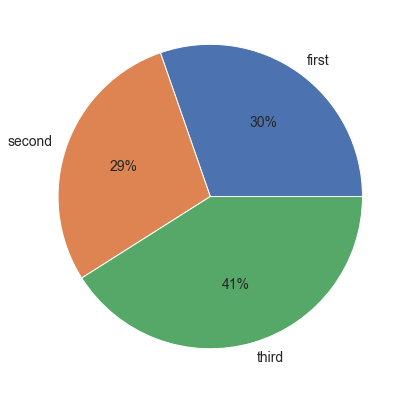

In [48]:
port_percent = data.groupby('Pclass')['Pclass'].count()
plt.figure(figsize=(7,7))
plt.pie(port_percent, labels = ['first', 'second', 'third'], autopct='%.0f%%', textprops={'fontsize': 14})

<AxesSubplot:xlabel='Pclass', ylabel='count'>

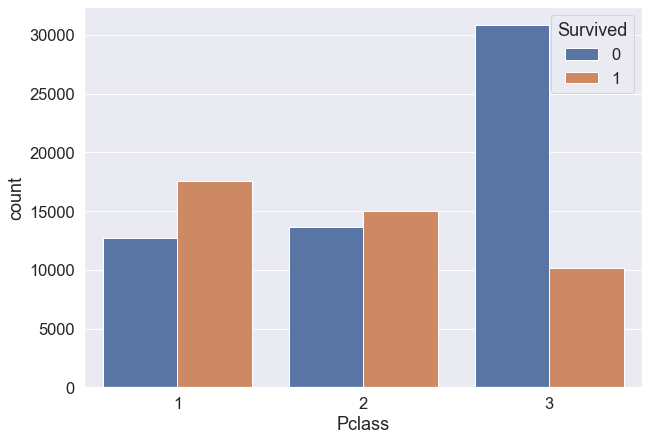

In [49]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.5)
sns.countplot(x=data["Pclass"],hue = data["Survived"],data = data)

The correlation is anticipated. Passengers in the top high class are being rescued first,
and the number of people in the 3rd class died is the largest.
But also overall there were more people in the 3rd class, least - in the 2nd.

In [50]:
emb_numb = data.groupby('Embarked')['Embarked'].count()
emb_numb

Embarked
C    22187
Q     5424
S    72139
Name: Embarked, dtype: int64

([<matplotlib.patches.Wedge at 0x121dffc70>,
 [Text(0.8421959007209375, 0.7076058682690873, 'Cherbourg'),
  Text(0.0026675524312146986, 1.0999967655243477, 'Queenstown'),
  Text(-0.7096461331313608, -0.8404774629528784, 'Southampton')],
 [Text(0.4593795822114204, 0.38596683723768394, '22%'),
  Text(0.001455028598844381, 0.5999982357405532, '5%'),
  Text(-0.38707970898074223, -0.4584422525197518, '72%')])

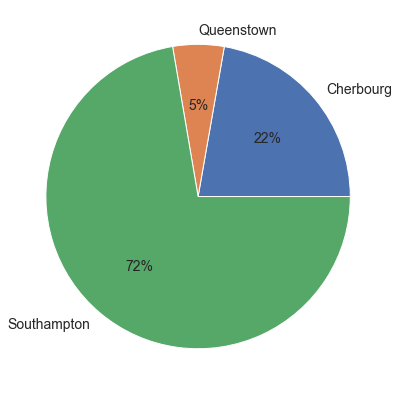

In [51]:
port_percent = data.groupby('Embarked')['Embarked'].count()
plt.figure(figsize=(7,7))
plt.pie(port_percent, labels = ['Cherbourg', 'Queenstown', 'Southampton'], autopct='%.0f%%', textprops={'fontsize': 14})

<AxesSubplot:xlabel='Embarked', ylabel='count'>

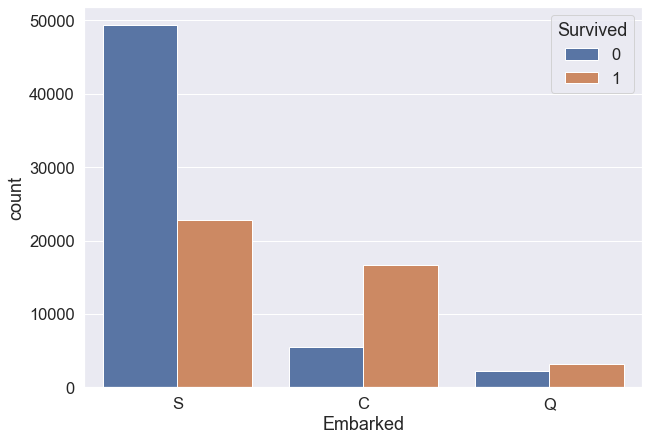

In [52]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.5)
sns.countplot(x=data["Embarked"],hue = data["Survived"],data = data)

Most people embarked in Southampton, the least - in Queenstown. Also most people died also embarked in Southampton, the least  - in Queenstown.
It seems like overall port in Southampton is the largest one and takes more people on average.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [53]:
pd.isna(data).sum()

Survived        0
Pclass          0
Name            0
Sex             0
Age          3292
SibSp           0
Parch           0
Ticket       4623
Fare          134
Cabin       67866
Embarked      250
dtype: int64

In [54]:
age_missing = data['Age'].isnull().sum() / len(data['Age']) * 100
age_missing

3.292

In [55]:
ticket_missing = data['Ticket'].isnull().sum() / len(data['Ticket']) * 100
ticket_missing

4.623

In [56]:
fare_missing = data['Fare'].isnull().sum() / len(data['Fare']) * 100
fare_missing

0.134

In [57]:
cabin_missing = data['Cabin'].isnull().sum() / len(data['Cabin']) * 100
cabin_missing

67.866

In [58]:
port_missing = data['Embarked'].isnull().sum() / len(data['Embarked']) * 100
port_missing

0.25

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

For "Ticket" and "Cabin" that are of object datatype, we canreplace NaN values with 'U' string = unknown;
NaN for "Fare" and 'Age' we'll impute by mean;
For "Embarked" we'll impute by the most frequent port of embarkation;

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [59]:
from sklearn.linear_model import LogisticRegression

In [60]:
train_data = pd.read_csv('data/titanic/train.csv')

In [61]:
y = train_data['Survived']
X = train_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
X[['Sex']] = np.where(X[['Sex']] == 'male', 0, 1)
X[["Fare"]].replace(np.NaN, X[["Fare"]].mean())
X["Embarked"] = X["Embarked"].fillna(X["Embarked"].value_counts().index[0])
X.at[X['Embarked'] == 'C'] = 0
X.at[X['Embarked'] == 'Q'] = 1
X.at[X['Embarked'] == 'S'] = 2
X[["Age"]].replace(np.NaN, X[["Age"]].mean())
scaler = StandardScaler()
X = scaler.fit_transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [62]:
log_mod = LogisticRegression(C=0.007, random_state=42)
log_mod.fit(X_train,y_train)
cross = cross_validate(log_mod, X_train, y_train, scoring='accuracy', cv=3)
print(cross['test_score'])

[0.69319448 0.69142416 0.69545279]


In [63]:
knn_mod = KNeighborsClassifier(n_neighbors=10)
knn_mod.fit(X_train,y_train)
cross_k = cross_validate(knn_mod, X_train, y_train, scoring='accuracy', cv=3)
print(cross_k['test_score'])

[0.69319448 0.68006686 0.69545279]


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [64]:
test_data = pd.read_csv('data/titanic/test.csv')

In [65]:
df_out = pd.DataFrame()
df_out['PassengerId'] = test_data.PassengerId
df_out['Survived'] = log_mod.predict(X)
df_out.to_csv('data/titanic/tit_redict.csv', index=False)

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.